In [ ]:
!pip install cirq
!pip install xlrd
!pip install pysf
!pip install openfermion
!pip install openfermionpyscf
!pip install openfermioncirq
import numpy as np

     |████████████████████████████████| 389kB 23.1MB/s 
     |████████████████████████████████| 1.5MB 38.6MB/s 
     |████████████████████████████████| 1.3MB 33.7MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 911kB 29.9MB/s 
     |████████████████████████████████| 1.8MB 32.6MB/s 
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-cp37-none-any.whl size=13837 sha256=b239a3fb6dcf006d10a365f12c7d19cafa2bf1c80ae4de676b0c320e0dea3431
  Stored in directory: /root/.cache/pip/wheels/10/4d/51/6b843681a9a5aef35f0d0fbce243de46f85080036e16118752
Successfully built pubchempy
  Found existing installation: cirq 0.11.0
    Uninstalling cirq-0.11.0:
      Successfully uninstalled cirq-0.11.0
     |████████████████████████████████| 29.7MB 144kB/s 
     |████████████████████████████████| 143kB 30.0MB/s 


In [ ]:
import cirq
import scipy
import pyscf
import openfermion
import openfermionpyscf 
import itertools
import time
import pickle
import matplotlib.pyplot as plt
import pickle

from google.colab import files
from openfermionpyscf import run_pyscf
from openfermion.utils import count_qubits, hermitian_conjugated
from openfermion.linalg import jw_hartree_fock_state
from openfermion.circuits import simulate_trotter
from openfermion.transforms import (
    jordan_wigner, get_fermion_operator, normal_ordered
)
from openfermion import (
    get_sparse_operator, get_ground_state, FermionOperator,
    jw_get_ground_state_at_particle_number, MolecularData,
    expectation, uccsd_convert_amplitude_format,
    get_interaction_operator, QubitOperator, eigenspectrum,
    InteractionOperator, FermionOperator
)

## Function Definitions

In [ ]:
# Define chemical accuracy
chemicalAccuracy = 1.5936*10**-3

# Define necessary Pauli operators (two-dimensional) as matrices
pauliX = np.array([[0,1],
                 [1,0]],
                dtype = complex)
pauliZ = np.array([[1,0],
                 [0,-1]],
                dtype = complex)
pauliY = np.array([[0,-1j],
                 [1j,0]],
                dtype = complex)

def stringToMatrix(pauliString):
  '''
  Converts a Pauli string to its matrix form.

  Arguments:
    pauliString (str): the Pauli string (e.g. "IXYIZ")

  Returns:
    matrix (np.ndarray): the corresponding matrix, in the computational basis

  '''

  matrix = np.array([1])

  # Iteratively construct the matrix, going through each single qubit Pauli term
  for pauli in pauliString:
      if pauli == "I":
        matrix = np.kron(matrix,np.identity(2))
      elif pauli == "X":
        matrix = np.kron(matrix,pauliX)
      elif pauli == "Y":
        matrix = np.kron(matrix,pauliY)
      elif pauli == "Z":
        matrix = np.kron(matrix,pauliZ)

  return matrix
  
def fromVectortoKet(stateVector):
  '''
  Transforms a vector representing a basis state to the corresponding ket.

  Arguments:
    stateVector (np.ndarray): computational basis vector in the 2^n dimensional 
      Hilbert space

  Returns:
    ket (list): a list of length n representing the corresponding ket 
  '''

  dim = len(stateVector)
  ket = []

  while dim>1:
    if any (stateVector[i] for i in range(int(dim/2))):
      # Ket is of the form |0>|...>. 

      #Fix |0> as the msq.
      ket.append(0)

      # Get the vector representing the state of the remaining qubits.
      stateVector = stateVector[:int(dim/2)]

    else:
      # Ket is of the form |1>|...>. 
      
      #Fix |0> as the msq.
      ket.append(1)

      # Get the vector representing the state of the remaining qubits.
      stateVector = stateVector[int(dim//2):]

    dim = dim/2

  return ket

def fromKettoVector(ket):
  '''
  Transforms a ket representing a basis state to the corresponding state vector.

  Arguments:
    ket (list): a list of length n representing the ket 

  Returns:
    stateVector (np.ndarray): the corresponding basis vector in the 
      2^n dimensional Hilbert space
  '''
  stateVector = [1]
  
  # Iterate through the ket, calculating the tensor product of the qubit states
  for i in ket:
    qubitVector = [not i,i]
    stateVector = np.kron(stateVector,qubitVector)

  return stateVector

def getHartreeFockKet(electronNumber,qubitNumber):
  '''
  Get the Hartree Fock ket |1>|1>...|0>|0>.

  Arguments:
    electronNumber (int): the number of electrons of the molecule.
    qubitNumber (int): the number of qubits necessary to represent the molecule
      (equal to the number of spin orbitals we're considering active).

  Returns:
    referenceKet (list): a list of lenght qubitNumber, representing the 
      ket of the adequate computational basis state in big-endian ordering.
  '''

  # Consider occupied the lower energy orbitals, until enough one particle 
  #states are filled
  referenceKet = [1 for _ in range(electronNumber)]

  # Consider the remaining orbitals empty
  referenceKet += [0 for _ in range(qubitNumber-electronNumber)]

  return referenceKet

def calculateOverlap(stateCoordinates1,stateCoordinates2):
    '''
    Calculates the overlap between two states, given their coordinates.

    Arguments:
      stateCoordinates1 (np.ndarray): the coordinates of one of the states in 
        some orthonormal basis,
      stateCoordinates2 (np.ndarray): the coordinates of the other state, in 
        the same basis

    Returns: 
      overlap (float): the overlap between two states (absolute value of the 
        inner product).
    '''

    bra = np.conj(stateCoordinates1)
    ket = stateCoordinates2
    overlap = np.abs(np.dot(bra,ket))
    
    return overlap

def findSubStrings(mainString,hamiltonian,checked = []):
    '''
    Finds and groups all the strings in a Hamiltonian that only differ from 
    mainString by identity operators.

    Arguments:
      mainString (str): a Pauli string (e.g. "XZ)
      hamiltonian (dict): a Hamiltonian (with Pauli strings as keys and their 
        coefficients as values)
      checked (list): a list of the strings in the Hamiltonian that have already
        been inserted in another group

    Returns: 
      groupedOperators (dict): a dictionary whose keys are boolean strings 
        representing substrings of the mainString (e.g. if mainString = "XZ", 
        "IZ" would be represented as "01"). It includes all the strings in the 
        hamiltonian that can be written in this form (because they only differ 
        from mainString by identities), except for those that were in checked
        (because they are already part of another group of strings).
      checked (list):  the same list passed as an argument, with extra values
        (the strings that were grouped in this function call).
    '''
    
    groupedOperators = {}
    
    # Go through the keys in the dictionary representing the Hamiltonian that 
    #haven't been grouped yet, and find those that only differ from mainString 
    #by identities
    for pauliString in hamiltonian:
        
        if pauliString not in checked:
            # The string hasn't been grouped yet
            
            if(all((op1 == op2 or op2 == "I") \
                   for op1,op2 in zip(mainString,pauliString))):
                # The string only differs from mainString by identities
                
                # Represent the string as a substring of the main one
                booleanString = "".join([str(int(op1 == op2)) for op1,op2 in \
                                       zip(mainString,pauliString)])
                    
                # Add the boolean string representing this string as a key to 
                #the dictionary of grouped operators, and associate its 
                #coefficient as its value
                groupedOperators[booleanString] = hamiltonian[pauliString]
                
                # Mark the string as grouped, so that it's not added to any 
                #other group
                checked.append(pauliString)
                
    return (groupedOperators,checked)

def groupHamiltonian(hamiltonian):
    '''
    Organizes a Hamiltonian into groups where strings only differ from 
    identities, so that the expectation values of all the strings in each 
    group can be calculated from the same measurement array.

    Arguments: 
      hamiltonian (dict): a dictionary representing a Hamiltonian, with Pauli 
        strings as keys and their coefficients as values.

    Returns: 
      groupedHamiltonian (dict): a dictionary of subhamiltonians, each of 
        which includes Pauli strings that only differ from each other by 
        identities. 
        The keys of groupedHamiltonian are the main strings of each group: the 
        ones with least identity terms. The value associated to a main string is 
        a dictionary, whose keys are boolean strings representing substrings of 
        the respective main string (with 1 where the Pauli is the same, and 0
        where it's identity instead). The values are their coefficients.
    '''
    groupedHamiltonian = {}
    checked = []
    
    # Go through the hamiltonian, starting by the terms that have less
    #identity operators
    for mainString in \
        sorted(hamiltonian,key = lambda pauliString: pauliString.count("I")):
            
        # Call findSubStrings to find all the strings in the dictionary that 
        #only differ from mainString by identities, and organize them as a 
        #dictionary (groupedOperators)
        groupedOperators,checked = findSubStrings(mainString,hamiltonian,checked)
        
        # Use the dictionary as a value for the mainString key in the 
        #groupedHamiltonian dictionary
        groupedHamiltonian[mainString] = groupedOperators
        
        # If all the strings have been grouped, exit the for cycle
        if(len(checked) == len(hamiltonian.keys())):
           break
       
    return groupedHamiltonian

def sampleEnergy(groupedHamiltonian,shots,statePreparationGates,qubits):
  '''
  Obtains the expectation value in a state by sampling (using the CIRQ 
  simulator).

  Arguments:
    groupedHamiltonian (dict): the Hamiltonian, grouped by terms that only differ
      by identities (as done by groupHamiltonian).
    shots (int): the number of circuit repetitions to be used.
    statePreparationGates (list): a list of CIRQ gates that prepare the state.
    qubits (list): a list of cirq.LineQubit to apply the gates on.

  Returns:
    energy (float): the energy (with sampling noise).
  '''

  energy = 0

  # Obtain the experimental expectation value for each Pauli string by
  #calling the measureExpectation function, and perform the necessary weighed
  #sum to obtain the energy expectation value
  for mainString in groupedHamiltonian:
      
      expectationValue = measureExpectation(mainString,
                                            groupedHamiltonian[mainString],
                                            shots,
                                            statePreparationGates,
                                            qubits)
      energy += expectationValue

  assert (energy.imag < 10**-5)

  return energy.real
    
def convertHamiltonian(openfermionHamiltonian):
  '''
  Formats a qubit Hamiltonian obtained from openfermion, so that it's a suitable
  argument for functions such as measureExpectationEstimation.

  Arguments:
    openfermionHamiltonian (openfermion.qubitOperator): the Hamiltonian.

  Returns:
    formattedHamiltonian (dict): the Hamiltonian as a dictionary with Pauli
      strings (eg 'YXZI') as keys and their coefficients as values.
  '''

  formattedHamiltonian = {}
  qubitNumber = count_qubits(openfermionHamiltonian)

  # Iterate through the terms in the Hamiltonian
  for term in openfermionHamiltonian.get_operators():
    
    operators = []
    coefficient = list(term.terms.values())[0]
    pauliString = list(term.terms.keys())[0]
    previousQubit = -1

    for (qubit,operator) in pauliString:

      # If there are qubits in which no operations are performed, add identities 
      #as necessary, to make sure that the length of the string will match the 
      #number of qubits
      identities = (qubit-previousQubit-1)

      if identities>0: 
        operators.append('I'*identities)

      operators.append(operator)
      previousQubit = qubit
    
    # Add final identity operators if the string still doesn't have the 
    #correct length (because no operations are performed in the last qubits)
    operators.append('I'*(qubitNumber-previousQubit-1))

    formattedHamiltonian["".join(operators)] = coefficient

  return formattedHamiltonian

def hamiltonianToMatrix(hamiltonian):
    '''
    Convert a Hamiltonian (from OpenFermion) to matrix form.
    
    Arguments:
      hamiltonian (openfermion.InteractionOperator): the Hamiltonian to be
        transformed.

    Returns:
      matrix (np.ndarray): the Hamiltonian, as a matrix in the computational 
        basis
    
    ''' 
    
    qubitNumber = hamiltonian.n_qubits
    
    hamiltonian = jordan_wigner(hamiltonian)

    formattedHamiltonian = convertHamiltonian(hamiltonian)
    groupedHamiltonian = groupHamiltonian(formattedHamiltonian)

    matrix = np.zeros((2**qubitNumber,2**qubitNumber),dtype = complex)

    # Iterate through the strings in the Hamiltonian, adding the respective 
    #contribution to the matrix
    for string in groupedHamiltonian:

      for substring in groupedHamiltonian[string]:
        pauli = ("".join("I"*(not int(b)) + a*int(b) \
                         for (a,b) in zip(string,substring)))
        
        matrix += stringToMatrix(pauli) * groupedHamiltonian[string][substring]

    return matrix

def measureString(pauliString,repetitions,statePreparationGates,qubits):
    ''' 
    Measures the expectation value of a Pauli string using the CIRQ simulator 
    (simulating sampling).

    Arguments:
      pauliString (str): the Pauli string to be measured.
      repetitions (int): the number of circuit repetitions to be used.
      statePreparationGates (list): the list of CIRQ gates that prepare the 
        state in which to obtain the expectation value.

    Returns: 
      expecationValue (float): the expectation value of pauliString, with 
        sampling noise.
    ''' 

    # Initialize circuit.
    circuit = cirq.Circuit(statePreparationGates)

    # Optimize circuit.
    cirq.optimizers.EjectZ().optimize_circuit(circuit)
    cirq.optimizers.DropNegligible().optimize_circuit(circuit)
    
    # Append necessary rotations and measurements for each qubit.
    for i in range(len(qubits)):
        op = pauliString[i]
        
        # Rotate qubit i to the X basis if that's the desired measurement.
        if (op == "X"):
            circuit.append(cirq.H(qubits[i]))
        
        # Rotate qubit i to the Y basis if that's the desired measurement.
        if (op == "Y"):
            circuit.append(cirq.rx(np.pi/2).on(qubits[i]))
            
        # Measure qubit i in the computational basis, unless operator is I.
        if (op != "I"):
            circuit.append(cirq.measure(qubits[i],key = i))
            
    # Sample the desired number of repetitions from the circuit, unless
    #there are no measurements (identity term).
    if (pauliString != "I"*len(qubits)):
        s = cirq.Simulator()
        results = s.run(circuit,repetitions = repetitions)
    #print(circuit)

    # Calculate the expectation value of the Pauli string by averaging over  
    #all the repetitions.
    
    total = 0
    
    for j in range(repetitions):
        meas = 1
        for i in range(len(qubits)):
            if (pauliString[i] != "I"):
                meas = meas*(1-2*results.data[i][j])
        total+=meas
        
    expectationValue = total/repetitions
    
    return expectationValue

def measureExpectation(mainString,subHamiltonian,repetitions,\
                       statePreparationGates,qubits):
    ''' 
    Measures the expectation value of a subHamiltonian using the CIRQ simulator 
    (simulating sampling). By construction, all the expectation values of the 
    strings in subHamiltonian can be obtained from the same measurement array.

    Arguments: 
      mainString (str): the main Pauli string. This is the string in the group
        with the least identity terms. It defines the circuit that will be used.
      subHamiltonian (dict): a dictionary whose keys are boolean strings
        representing substrings of the main one, and whose values are the 
        respective coefficients.
      repetitions (int): the number of repetitions to be performed, the 
      statePreparationGates (list): the list of CIRQ gates that prepare (from 
        |0..0>) the state in which to obtain the expectation value.
      qubits (list): list of cirq.LineQubit to apply the gates on

    Returns:
      totalExpectationValue (float): the total expectation value of 
        subHamiltonian, with sampling noise.
    ''' 
    
    # Initialize circuit.
    circuit = cirq.Circuit()
    
    # Append to the circuit the gates that prepare the state corresponding to
    #the received parameters.
    circuit.append(statePreparationGates)
    cirq.optimizers.EjectZ().optimize_circuit(circuit)
    cirq.optimizers.DropNegligible().optimize_circuit(circuit)
    
    # Append necessary rotations and measurements for each qubit.
    for i in range(len(qubits)):
        op = mainString[i]
        
        # Rotate qubit i to the X basis if that's the desired measurement.
        if (op == "X"):
            circuit.append(cirq.H(qubits[i]))
            
        # Rotate qubit i to the Y basis if that's the desired measurement.
        if (op == "Y"):
            circuit.append(cirq.rx(np.pi/2).on(qubits[i]))
            
        #Measure qubit i in the computational basis, unless operator is I.
        if (op != "I"):
            circuit.append(cirq.measure(qubits[i],key = i))
            
    # Sample the desired number of repetitions from the circuit, unless
    #there are no measurements (identity term).
    if (mainString != "I"*len(qubits)):
        s = cirq.Simulator()
        results = s.run(circuit,repetitions = repetitions)

    # For each substring, initialize the sum of all measurements as zero
    total = {}
    for subString in subHamiltonian:
        total[subString] = 0
    
    # Calculate the expectation value of each Pauli string by averaging over  
    #all the repetitions
    for j in range(repetitions):
        meas = {}
        
        # Initialize the measurement in repetition j for all substrings
        for subString in subHamiltonian:
            meas[subString] = 1
        
        # Go through the measurements on all the qubits
        for i in range(len(qubits)):
            
            if (mainString[i] != "I"):
                # There's a measurement associated with this qubit
                
                # Use this single qubit measurement for the calculation of the
                #measurement of each full substring in this repetition. If the
                #substring has a "0" in the position corresponding to this
                #qubit, the operator associated is I, and the measurement
                #is ignored (raised to the power of 0)
                for subString in subHamiltonian:
                    meas[subString] = meas[subString]*((1-2*results.data[i][j])\
                                                     **int(subString[i]))
                        
        # Add this measurement to the total, for each string
        for subString in subHamiltonian:
            total[subString]+=meas[subString]
        
    totalExpectationValue = 0
    
    # Calculate the expectation value of the subHamiltonian, by multiplying
    #the expectation value of each substring by the respective coefficient
    for subString in subHamiltonian:
        
        # Get the expectation value of this substring by taking the average
        #over all the repetitions
        expectationValue = total[subString]/repetitions
        
        # Add this value to the total expectation value, weighed by its 
        #coefficient
        totalExpectationValue+=expectationValue*subHamiltonian[subString]
    
    return totalExpectationValue

def stateEnergy(stateCoordinates,hamiltonian):
    ''' 
    Calculates the exact energy in a specific state.

    Arguments:
      stateCoordinates (np.ndarray): the state in which to obtain the 
        expectation value.
      hamiltonian (dict): the Hamiltonian of the system.
    
    Returns:
      exactEnergy (float): the energy expecation value in the state.
    ''' 

    exactEnergy = 0
    
    # Obtain the theoretical expectation value for each Pauli string in the
    #Hamiltonian by matrix multiplication, and perform the necessary weighed
    #sum to obtain the energy expectation value.
    for pauliString in hamiltonian:
        
        ket = np.array(stateCoordinates,dtype = complex)
        bra = np.conj(ket)
        
        ket = np.matmul(stringToMatrix(pauliString),ket)
        expectationValue = np.real(np.dot(bra,ket))
        
        exactEnergy+=\
            hamiltonian[pauliString]*expectationValue
            
    return exactEnergy

def trotterStep(operator,qubits,time): 
  '''
  Creates the circuit for applying e^(-j*operator*time), simulating the time
  evolution of a state under the Hamiltonian 'operator'.

  Arguments:
    operator (union[openfermion.QubitOperator, openfermion.FermionOperator,
      openfermion.InteractionOperator]): the operator to be simulated
    qubits ([cirq.LineQubit]): the qubits that the gates should be applied to
    time (float): the evolution time

  Returns:
    trotterGates (cirq.OP_TREE): the list of CIRQ gates that apply the 
      trotterized operator
  '''

  # If operator is an InteractionOperator, shape it into a FermionOperator
  if isinstance(operator,InteractionOperator):
    operator = get_fermion_operator(operator)

  # If operator is a FermionOperator, use the Jordan Wigner transformation
  #to map it into a QubitOperator
  if isinstance(operator,FermionOperator):
    operator = jordan_wigner(operator)
  
  # Get the number of qubits the operator acts on
  qubitNumber = count_qubits(operator)

  # Initialize list of gates
  trotterGates = []

  # Order the terms the same way as done by OpenFermion's 
  #trotter_operator_grouping function (sorted keys) for consistency.
  orderedTerms = sorted(list(operator.terms.keys()))

  # Add to trotterGates the gates necessary to simulate each Pauli string,
  #going through them by the defined order
  for pauliString in orderedTerms:

    # Get real part of the coefficient (the immaginary one can't be simulated,
    #as the exponent would be real and the operation would not be unitary).
    # Multiply by time to get the full multiplier of the Pauli string.
    coef = float(np.real(operator.terms[pauliString]))*time

    # Keep track of the qubit indices involved in this particular Pauli string.
    # It's necessary so as to know which are included in the sequence of CNOTs 
    #that compute the parity
    involvedQubits = []

    # Perform necessary basis rotations
    for pauli in pauliString:

      # Get the index of the qubit this Pauli operator acts on
      qubitIndex = pauli[0]
      involvedQubits.append(qubitIndex)

      # Get the Pauli operator identifier (X,Y or Z)
      pauliOp = pauli[1]

      if pauliOp == "X":
        # Rotate to X basis
        trotterGates.append(cirq.H(qubits[qubitIndex]))

      if pauliOp == "Y":
        # Rotate to Y Basis
        trotterGates.append(cirq.rx(np.pi/2).on(qubits[qubitIndex]))

    # Compute parity and store the result on the last involved qubit
    for i in range(len(involvedQubits)-1):

      control = involvedQubits[i]
      target = involvedQubits[i+1]

      trotterGates.append(cirq.CX(qubits[control],qubits[target]))
    
    # Apply e^(-i*Z*coef) = Rz(coef*2) to the last involved qubit
    lastQubit = max(involvedQubits)
    trotterGates.append(cirq.rz(2*coef).on(qubits[lastQubit]))

    # Uncompute parity
    for i in range(len(involvedQubits)-2,-1,-1):

      control = involvedQubits[i]
      target = involvedQubits[i+1]

      trotterGates.append(cirq.CX(qubits[control],qubits[target]))

    # Undo basis rotations
    for pauli in pauliString:

      # Get the index of the qubit this Pauli operator acts on
      qubitIndex = pauli[0]

      # Get the Pauli operator identifier (X,Y or Z)
      pauliOp = pauli[1]

      if pauliOp == "X":
        # Rotate to Z basis from X basis
        trotterGates.append(cirq.H(qubits[qubitIndex]))

      if pauliOp == "Y":
        # Rotate to Z basis from Y Basis
        trotterGates.append(cirq.rx(-np.pi/2).on(qubits[qubitIndex]))

  return trotterGates

def trotterizeOperator(operator,qubits,time,steps):
  '''
  Creates the circuit for applying e^(-j*operator*time), simulating the time
  evolution of a state under the Hamiltonian 'operator', with the given 
  number of steps. 
  Increasing the number of steps increases precision (unless the terms in the 
  operator commute, in which case steps = 1 is already exact).
  For the same precision, a greater time requires a greater step number
  (again, unless the terms commute)

  Arguments:
    operator (union[openfermion.QubitOperator, openfermion.FermionOperator,
      openfermion.InteractionOperator]): the operator to be simulated
    qubits ([cirq.LineQubit]): the qubits that the gates should be applied to
    time (float): the evolution time
    steps (int): the number of trotter steps to split the time evolution into

  Returns:
    trotterGates (cirq.OP_TREE): the list of CIRQ gates that apply the 
      trotterized operator
  '''
  
  trotterGates = []
  
  # Divide time into steps and apply the evolution operator the necessary 
  #number of times
  for step in range(1,steps+1):
    trotterGates += (trotterStep(operator,qubits,time/steps))
  
  return trotterGates

## Molecule Definitions


In [ ]:
# H2
geometry = [['H',[0,0,0]],['H',[0,0,0.74]]]
basis = 'sto-3g'
multiplicity = 1
charge = 0
h2molecule = MolecularData(geometry,basis,multiplicity,charge,description='H2')
h2molecule = run_pyscf(h2molecule,run_fci = True,run_ccsd = True)

# HeH+
r = 0.5 # radius in angstrom
geometry = [['He',[0,0,0]],['H',[0,0,2*r]]]
basis = 'sto-3g'
multiplicity = 1
charge = +1
helonium = MolecularData(geometry,basis,multiplicity,charge,description='HeH+')
helonium = run_pyscf(helonium,run_fci = True,run_ccsd = True)

# LiH
bondLength = 1.45 # bond length in angstrom
geometry = [['Li',[0,0,0]],['H',[0,0,bondLength]]]
basis = 'sto-3g'
multiplicity = 1
charge = 0
liH = MolecularData(geometry,basis,multiplicity,charge,description='LiH')
liH = run_pyscf(liH,run_fci = True,run_ccsd = True)

# Alternative to using run_pyscf: load from OpenFermion (data for this 
#particular molecule at this particule radius is available in a file that comes
#with OF)
liHOF = MolecularData(geometry,basis,multiplicity,charge,description = '1.45')
liHOF.load()

## Choosing the Molecule

In [ ]:
molecule = helonium
name = molecule.description
bondLength = molecule.geometry[1][1][2]

Get some data on the molecule. Only necessary for building the pools and testing; the functions are independent of previous data, and rely only on the MolecularData object.

In [ ]:
electronNumber = molecule.n_electrons
orbitalNumber = molecule.n_orbitals
qubitNumber = molecule.n_qubits

hfState = jw_hartree_fock_state(electronNumber,orbitalNumber*2) 

hamiltonian = molecule.get_molecular_hamiltonian() 

# Get the matrix representing the Hamiltonian, as a scipy.sparse.csc_matrix
sparseHamiltonian = get_sparse_operator(hamiltonian,qubitNumber)

## Pool Definitions

Code for creating the fermionic pools (singlet_sd, singlet_gsd, spin_complement_gsd) taken from [the GitHub repository with the original Adapt-VQE implementation](https://github.com/mayhallgroup/adapt-vqe).

### Singlet Singles and Doubles

In [ ]:
singlet_sd = []

n_occ = int(np.ceil(electronNumber / 2))
n_vir = orbitalNumber - n_occ

for i in range(0,n_occ):
    ia = 2*i
    ib = 2*i+1

    for a in range(0,n_vir):
        aa = 2*n_occ + 2*a
        ab = 2*n_occ + 2*a+1

        termA =  FermionOperator(((aa,1),(ia,0)), 1/np.sqrt(2))
        termA += FermionOperator(((ab,1),(ib,0)), 1/np.sqrt(2))

        termA -= hermitian_conjugated(termA)

        termA = normal_ordered(termA)

        #Normalize
        coeffA = 0
        for t in termA.terms:
            coeff_t = termA.terms[t]
            coeffA += coeff_t * coeff_t

        if termA.many_body_order() > 0:
            termA = termA/np.sqrt(coeffA)
            singlet_sd.append(termA)


for i in range(0,n_occ):
    ia = 2*i
    ib = 2*i+1

    for j in range(i,n_occ):
        ja = 2*j
        jb = 2*j+1

        for a in range(0,n_vir):
            aa = 2*n_occ + 2*a
            ab = 2*n_occ + 2*a+1

            for b in range(a,n_vir):
                ba = 2*n_occ + 2*b
                bb = 2*n_occ + 2*b+1

                termA =  FermionOperator(((aa,1),(ba,1),(ia,0),(ja,0)), 2/np.sqrt(12))
                termA += FermionOperator(((ab,1),(bb,1),(ib,0),(jb,0)), 2/np.sqrt(12))
                termA += FermionOperator(((aa,1),(bb,1),(ia,0),(jb,0)), 1/np.sqrt(12))
                termA += FermionOperator(((ab,1),(ba,1),(ib,0),(ja,0)), 1/np.sqrt(12))
                termA += FermionOperator(((aa,1),(bb,1),(ib,0),(ja,0)), 1/np.sqrt(12))
                termA += FermionOperator(((ab,1),(ba,1),(ia,0),(jb,0)), 1/np.sqrt(12))

                termB  = FermionOperator(((aa,1),(bb,1),(ia,0),(jb,0)), 1/2)
                termB += FermionOperator(((ab,1),(ba,1),(ib,0),(ja,0)), 1/2)
                termB += FermionOperator(((aa,1),(bb,1),(ib,0),(ja,0)), -1/2)
                termB += FermionOperator(((ab,1),(ba,1),(ia,0),(jb,0)), -1/2)

                termA -= hermitian_conjugated(termA)
                termB -= hermitian_conjugated(termB)

                termA = normal_ordered(termA)
                termB = normal_ordered(termB)

                #Normalize
                coeffA = 0
                coeffB = 0
                for t in termA.terms:
                    coeff_t = termA.terms[t]
                    coeffA += coeff_t * coeff_t
                for t in termB.terms:
                    coeff_t = termB.terms[t]
                    coeffB += coeff_t * coeff_t

                if termA.many_body_order() > 0:
                    termA = termA/np.sqrt(coeffA)
                    singlet_sd.append(termA)

                if termB.many_body_order() > 0:
                    termB = termB/np.sqrt(coeffB)
                    singlet_sd.append(termB)

print("Pool size:",len(singlet_sd))

Pool size: 2


### Singlet Generalized Singles and Doubles

**for** each spatial orbital $p$:
> **for** each spatial orbital $ q\geq p$:
>> $\hat{\tau}_1 = \lvert p \rangle \langle q \lvert + \lvert \bar{p} \rangle \langle \bar{q} \lvert $\
>> $\hat{\tau}_1 = \hat{\tau}_1 - \hat{\tau}_1^\dagger$\
>> Normal order $\hat{\tau}_1$\
>> **if** $\hat{\tau}_1$ **is not** $0$:
>>> Normalize $\hat{\tau}_1$ \
>>> Add $\hat{\tau}_1$ to the pool

**for** each spatial orbital $p$:
> **for** each spatial orbital $ q\geq p$:
>> **for** each spatial orbital $r$:
>>> **for** each spatial orbital $ s\geq r$:
>>>> **if** $(r,s) \geq (p,q)$ according to some unique ordering:
>>>>> $\hat{\tau}_{2,A} = -\frac{2}{\sqrt{12}} \lvert rs \rangle \langle pq \lvert$
>>>>> $\hat{\tau}_{2,A} = \hat{\tau}_{2,A} -\frac{2}{\sqrt{12}}\frac{1}{2}\left( \lvert r\bar{s} \rangle + \lvert \bar{r} s\rangle \right)\left( \langle p\bar{q} \lvert + \langle \bar{p} q\lvert \right) $
>>>>> $\hat{\tau}_{2,A} = \hat{\tau}_{2,A} -\frac{2}{\sqrt{12}} \lvert \bar{r}\bar{s} \rangle \langle \bar{p}\bar{q} \lvert$\
>>>>> $\hat{\tau}_{2,A} = \hat{\tau}_{2,A} - \hat{\tau}_{2,A}^\dagger$\
>>>>> $\hat{\tau}_{2,B} = -\frac{1}{2}\left( \lvert r\bar{s} \rangle - \lvert \bar{r} s\rangle \right)\left( \langle p\bar{q} \lvert - \langle \bar{p} q\lvert \right) $\
>>>>> $\hat{\tau}_{2,B} = \hat{\tau}_{2,B} - \hat{\tau}_{2,B}^\dagger$\
>>>>> Normal order $\hat{\tau}_{2,A}$\, $\hat{\tau}_{2,B}$\
>>>>> **for** $\hat{\tau}_{2}$ in {$\hat{\tau}_{2,A}$,$\hat{\tau}_{2,B}$}:
>>>>>> if $\hat{\tau}_{2}$  **is not** $0$:
>>>>>>> Normalize $\hat{\tau}_{2}$ \
>>>>>>> Add $\hat{\tau}_{2}$  to the pool

Second quantization formalism:

$\hat{\tau}_1 = a_p^\dagger a_q +a_\bar{p}^\dagger a_\bar{q} - h.c.$

$\hat{\tau}_{2,A} = \frac{1}{\sqrt{12}} \left( 2a_r^\dagger a_p a_s^\dagger a_q  + 2a_\bar{r}^\dagger a_\bar{p} a_\bar{s}^\dagger a_\bar{q} + a_r^\dagger a_p a_\bar{s}^\dagger a_\bar{q} + a_\bar{r}^\dagger a_\bar{p} a_s^\dagger a_q + a_r^\dagger a_\bar{p} a_\bar{s}^\dagger a_q + a_\bar{r}^\dagger a_p a_s^\dagger a_\bar{q} \right) - h.c.$

$\hat{\tau}_{2,B} = \frac{1}{2}\left(a_r^\dagger a_p a_\bar{s}^\dagger a_\bar{q} + a_\bar{r}^\dagger a_\bar{p} a_s^\dagger a_q - a_r^\dagger a_\bar{p} a_\bar{s}^\dagger a_q - a_\bar{r}^\dagger a_p a_s^\dagger a_\bar{q} \right) - h.c.$

First quantization formalism:

$\hat{\tau}_1 = \lvert p \rangle \langle q \lvert + \lvert \bar{p} \rangle \langle \bar{q} \lvert - h.c.$

$\hat{\tau}_{2,A} = -\frac{2}{\sqrt{12}} \left(\lvert rs \rangle \langle pq \lvert + \frac{1}{2}\left( \lvert r\bar{s} \rangle + \lvert \bar{r} s\rangle \right)\left( \langle p\bar{q} \lvert + \langle \bar{p} q\lvert \right) + \lvert \bar{r}\bar{s} \rangle \langle \bar{p}\bar{q} \lvert \right)-h.c.$
$= -\frac{2}{\sqrt{12}} \left(\lvert s=1,s_z=1 \rangle_{rs} \langle s=1,s_z=1 \lvert_{pq} + \lvert s=1,s_z=0 \rangle_{rs} \langle s=1,s_z=0 \lvert_{pq} +  \lvert s=1,s_z=-1 \rangle_{rs} \langle s=1,s_z=-1 \lvert_{pq} \right) - h.c $

$\hat{\tau}_{2,B} = -\frac{1}{2}\left( \lvert r\bar{s} \rangle - \lvert \bar{r} s\rangle \right)\left( \langle p\bar{q} \lvert - \langle \bar{p} q\lvert \right) - h.c. $

$ = -\frac{1}{2} \lvert s=0,s_z=0 \rangle_{rs} \langle s=0,s_z=0 \lvert_{pq} - h.c.$

In [ ]:
singlet_gsd = []

for p in range(0,orbitalNumber):
    pa = 2*p
    pb = 2*p+1

    for q in range(p,orbitalNumber):
        qa = 2*q
        qb = 2*q+1

        termA =  FermionOperator(((pa,1),(qa,0)))
        termA += FermionOperator(((pb,1),(qb,0)))

        termA -= hermitian_conjugated(termA)
        termA = normal_ordered(termA)

        #Normalize
        coeffA = 0
        for t in termA.terms:
            coeff_t = termA.terms[t]
            coeffA += coeff_t * coeff_t

        if termA.many_body_order() > 0:
            termA = termA/np.sqrt(coeffA)
            singlet_gsd.append(termA)


pq = -1
for p in range(0,orbitalNumber):
    pa = 2*p
    pb = 2*p+1

    for q in range(p,orbitalNumber):
        qa = 2*q
        qb = 2*q+1

        pq += 1

        rs = -1
        for r in range(0,orbitalNumber):
            ra = 2*r
            rb = 2*r+1

            for s in range(r,orbitalNumber):
                sa = 2*s
                sb = 2*s+1

                rs += 1

                if(pq > rs):
                    continue

                termA =  FermionOperator(((ra,1),(pa,0),(sa,1),(qa,0)), 2/np.sqrt(12))
                termA += FermionOperator(((rb,1),(pb,0),(sb,1),(qb,0)), 2/np.sqrt(12))
                termA += FermionOperator(((ra,1),(pa,0),(sb,1),(qb,0)), 1/np.sqrt(12))
                termA += FermionOperator(((rb,1),(pb,0),(sa,1),(qa,0)), 1/np.sqrt(12))
                termA += FermionOperator(((ra,1),(pb,0),(sb,1),(qa,0)), 1/np.sqrt(12))
                termA += FermionOperator(((rb,1),(pa,0),(sa,1),(qb,0)), 1/np.sqrt(12))

                termB =  FermionOperator(((ra,1),(pa,0),(sb,1),(qb,0)),  1/2.0)
                termB += FermionOperator(((rb,1),(pb,0),(sa,1),(qa,0)),  1/2.0)
                termB += FermionOperator(((ra,1),(pb,0),(sb,1),(qa,0)), -1/2.0)
                termB += FermionOperator(((rb,1),(pa,0),(sa,1),(qb,0)), -1/2.0)

                termA -= hermitian_conjugated(termA)
                termB -= hermitian_conjugated(termB)

                termA = normal_ordered(termA)
                termB = normal_ordered(termB)

                #Normalize
                coeffA = 0
                coeffB = 0
                for t in termA.terms:
                    coeff_t = termA.terms[t]
                    coeffA += coeff_t * coeff_t
                for t in termB.terms:
                    coeff_t = termB.terms[t]
                    coeffB += coeff_t * coeff_t


                if termA.many_body_order() > 0:
                    termA = termA/np.sqrt(coeffA)
                    singlet_gsd.append(termA)

                if termB.many_body_order() > 0:
                    termB = termB/np.sqrt(coeffB)
                    singlet_gsd.append(termB)

print("Pool size:",len(singlet_gsd))

Pool size: 4


### Spin Complement Generalized Singles and Doubles

**for** each spatial orbital $p$:
> **for** each spatial orbital $ q\geq p$:
>> $\hat{\tau}_1 = \lvert p \rangle \langle q \lvert + \lvert \bar{p} \rangle \langle \bar{q} \lvert $\
>> $\hat{\tau}_1 = \hat{\tau}_1 - \hat{\tau}_1^\dagger$\
>> Normal order $\hat{\tau}_1$\
>> **if** $\hat{\tau}_1$ **is not** $0$:
>>> Add $\hat{\tau}_1$ to the pool

**for** each spatial orbital $p$:
> **for** each spatial orbital $ q\geq p$:
>> **for** each spatial orbital $r$:
>>> **for** each spatial orbital $ s\geq r$:
>>>> **if** $(r,s) \geq (p,q)$ according to some unique ordering:
>>>>> $\hat{\tau}_{2,A} = - \left(\lvert rs \rangle \langle pq \lvert +\lvert \bar{r}\bar{s} \rangle \langle \bar{p}\bar{q} \lvert \right)$\
>>>>> $\hat{\tau}_{2,A} = \hat{\tau}_{2,A} - \hat{\tau}_{2,A}^\dagger$\
>>>>> $\hat{\tau}_{2,B} =- \left(\lvert r\bar{s} \rangle \langle p\bar{q} \lvert +\lvert \bar{r}s \rangle \langle \bar{p}q \lvert \right) $\
>>>>> $\hat{\tau}_{2,B} = \hat{\tau}_{2,B} - \hat{\tau}_{2,B}^\dagger$\
>>>>> $\hat{\tau}_{2,C} =- \left(\lvert r\bar{s} \rangle \langle \bar{p}q \lvert +\lvert \bar{r}s \rangle \langle p\bar{q} \lvert \right)$\
>>>>> $\hat{\tau}_{2,C} = \hat{\tau}_{2,C} - \hat{\tau}_{2,C}^\dagger$\
>>>>> Normal order $\hat{\tau}_{2,A}$\, $\hat{\tau}_{2,B}$\, $\hat{\tau}_{2,C}$\
>>>>> **for** $\hat{\tau}_{2}$ in {$\hat{\tau}_{2,A}$,$\hat{\tau}_{2,B}$,$\hat{\tau}_{2,C}$}:
>>>>>> if $\hat{\tau}_{2}$  **is not** $0$:
>>>>>>> Add $\hat{\tau}_{2}$  to the pool

First quantization formalism:

$\hat{\tau}_1 = \lvert p \rangle \langle q \lvert + \lvert \bar{p} \rangle \langle \bar{q} \lvert - h.c.$

$\hat{\tau}_{2,A} = - \left(\lvert rs \rangle \langle pq \lvert +\lvert \bar{r}\bar{s} \rangle \langle \bar{p}\bar{q} \lvert \right) - h.c. $

$\hat{\tau}_{2,B} =- \left(\lvert r\bar{s} \rangle \langle p\bar{q} \lvert +\lvert \bar{r}s \rangle \langle \bar{p}q \lvert \right) - h.c. $

$\hat{\tau}_{2,C} =- \left(\lvert r\bar{s} \rangle \langle \bar{p}q \lvert +\lvert \bar{r}s \rangle \langle p\bar{q} \lvert \right) - h.c. $


In [ ]:
# spin_complement_gsd

spin_complement_gsd = []
for p in range(0,orbitalNumber):
    pa = 2*p
    pb = 2*p+1

    for q in range(p,orbitalNumber):
        qa = 2*q
        qb = 2*q+1

        termA =  FermionOperator(((pa,1),(qa,0)))
        termA += FermionOperator(((pb,1),(qb,0)))

        termA -= openfermion.hermitian_conjugated(termA)

        termA = openfermion.normal_ordered(termA)

        if termA.many_body_order() > 0:
            spin_complement_gsd.append(termA)


pq = -1
for p in range(0,orbitalNumber):
    pa = 2*p
    pb = 2*p+1

    for q in range(p,orbitalNumber):
        qa = 2*q
        qb = 2*q+1

        pq += 1

        rs = -1
        for r in range(0,orbitalNumber):
            ra = 2*r
            rb = 2*r+1

            for s in range(r,orbitalNumber):
                sa = 2*s
                sb = 2*s+1

                rs += 1

                if(pq > rs):
                    continue

                termA =  FermionOperator(((ra,1),(pa,0),(sa,1),(qa,0)))
                termA += FermionOperator(((rb,1),(pb,0),(sb,1),(qb,0)))

                termB =  FermionOperator(((ra,1),(pa,0),(sb,1),(qb,0)))
                termB += FermionOperator(((rb,1),(pb,0),(sa,1),(qa,0)))

                termC =  FermionOperator(((ra,1),(pb,0),(sb,1),(qa,0)))
                termC += FermionOperator(((rb,1),(pa,0),(sa,1),(qb,0)))

                termA -= openfermion.hermitian_conjugated(termA)
                termB -= openfermion.hermitian_conjugated(termB)
                termC -= openfermion.hermitian_conjugated(termC)

                termA = openfermion.normal_ordered(termA)
                termB = openfermion.normal_ordered(termB)
                termC = openfermion.normal_ordered(termC)

                if termA.many_body_order() > 0:
                  spin_complement_gsd.append(termA)

                if termB.many_body_order() > 0:
                    spin_complement_gsd.append(termB)

                if termC.many_body_order() > 0:
                    spin_complement_gsd.append(termC)

print("Pool Size:",len(spin_complement_gsd))

Pool Size: 7


### Qubit Pool

The qubit pool is as defined in qubit-ADAPT-VQE ([arxiv:1911.10205](https://arxiv.org/abs/1911.10205)). It consists of all unique Pauli strings appearing in the spin adapted generealized excitations (*singlet_gsd*).

In [ ]:
pool = singlet_gsd

qubitPool = []

for fermionOp in pool:

  qubitOp = jordan_wigner(fermionOp)
  
  for pauli in qubitOp.terms:

    qubitOp = QubitOperator(pauli,1j)

    if qubitOp not in qubitPool:
      qubitPool.append(qubitOp)

print("Pool Size:",len(qubitPool))

Pool Size: 20


## Energy Calculation Functions

### Matrix algebra (no trotterization, no sampling noise)

In [ ]:
def exactAdaptEnergy(coefVect,operators,referenceState,sparseHamiltonian):
  '''
  Calculates the energy of the state prepared by applying an ansatz (of the 
  type of the Adapt VQE protocol) to a reference state.
  Uses instances of scipy.sparse.csc_matrix for efficiency.

  Arguments:
    coefVect ([float]): the list of coefficients of the ansatz operators.
    operators (union[openfermion.FermionOperator,openfermion.QubitOperator]): 
      the list of ansatz operators (fermionic ladder operators, pre 
      exponentiation). The index of the operators in the list should be in 
      accordance with the index of the respective coefficients in coefVect.
    referenceState (numpy.ndarray): the state vector representing the state 
      prior to the application of the ansatz (e.g. the Hartree Fock ground 
      state).
    sparseHamiltonian (scipy.sparse.csc_matrix): the hamiltonian of the system, 
      as a sparse matrix.

    Returns:
      energy (float): the expectation value of the Hamiltonian in the state
        prepared by applying the ansatz to the reference state.
  '''

  # Find the number of qubits of the system (2**qubitNumber = dimension)
  dimension, _ = sparseHamiltonian.shape
  qubitNumber = int(np.log(dimension)/np.log(2)) 
  
  # Transform reference vector into a Compressed Sparse Column matrix
  ket = scipy.sparse.csc_matrix(referenceState,dtype=complex).transpose()

  # Apply e ** (coefficient * operator) to the state (ket) for each operator in 
  #the ansatz, following the order of the list
  for (coefficient,operator) in zip(coefVect,operators):

    # Multiply the operator by the respective coefficient
    operator = coefficient*operator

    # Get the sparse matrix representing the operator. The dimension should be 
    #that of the FULL Hilbert space, even if the operator only acts on part.
    sparseOperator = get_sparse_operator(operator,qubitNumber)

    # Exponentiate the operator and update ket to represent the state after
    #this operator has been applied
    expOperator = scipy.sparse.linalg.expm(sparseOperator)
    ket = expOperator * ket

  # Get the corresponding bra and calculate the energy: |<bra| H |ket>|
  bra = ket.transpose().conj()
  energy = (bra * sparseHamiltonian * ket)[0,0].real
  
  return energy

### CIRQ simulator (trotterization and/or sampling noise)

In [ ]:
def getAdaptEnergy(coefficients,ansatz,molecule,shots,qubitHamiltonian = None, trotter = True, steps = 1, sample = True):
  '''
  Obtains the energy of the state prepared by applying an ansatz (of the 
  type of the Adapt VQE protocol) to a reference state, using the CIRQ simulator.

  Arguments:
    coefficients ([float]): the list of coefficients of the ansatz operators.
    ansatz ([openfermion.FermionOperator]): the list of ansatz operators 
      (fermionic ladder operators, pre exponentiation). The index of the 
      operators in the list should be in accordance with the index of the 
      respective coefficients in coefVect.
    molecule (openfermion.MolecularData): the molecule in study, whose ground
      state we're trying to determine
    shots (int): the number of circuit repetitions to use to get the 
      expectation value. The precision of the estimate goes like 1/sqrt(shots)
    trotter (bool): whether to trotterize the ansatz. If False, the corresponding
      matrix will be applied directly using a cirq.MatrixGate.
    steps (int): the number of trotter steps to be used in the trotterization.
    sample (bool): whether to sample from the circuit. If False, the full 
      wavevector will be simulated, and the final energy will be calculated
      anallytically.

    Returns:
      energy (float): the expectation value of the Hamiltonian in the state
        prepared by applying the ansatz to the reference state, with trotter
        error (if trotter = True) and sampling noise (if sample = True)
  '''  

  if qubitHamiltonian is None:
    # Get the fermionic Hamiltonian for this molecule
    hamiltonian = molecule.get_molecular_hamiltonian()

    # Map it into a qubit Hamiltonian using the Jordan Wigner transform, and
    #compress it to remove negligeable terms
    qubitHamiltonian = jordan_wigner(hamiltonian)
    qubitHamiltonian.compress()

  # Format and group the Hamiltonian, so as to save measurements by using
  #the same data for Pauli strings that only differ by identities
  formattedHamiltonian = convertHamiltonian(qubitHamiltonian)
  groupedHamiltonian = groupHamiltonian(formattedHamiltonian)

  # Count the number of qubits the Hamiltonian acts on
  qubitNumber = count_qubits(qubitHamiltonian)

  # Get the number of electrons of the molecule
  electronNumber = molecule.n_electrons

  # Initialize qubits
  qubits = cirq.LineQubit.range(qubitNumber)

  # Create the gates for preparing the Hartree Fock ground state, that serves 
  #as a reference state the ansatz will act on
  hfGates = [cirq.X(qubits[i]) for i in range(electronNumber)]

  # If the trotter flag is set, trotterize the operators into a CIRQ circuit
  if trotter:

    # Initialize the ansatz gate list
    trotterAnsatz = []

    # Go through the operators in the ansatz
    for (coefficient,fermionOperator) in zip(coefficients,ansatz):

      # Get the trotterized circuit for applying e**(operator*coefficient)
      operatorTrotterCircuit = trotterizeOperator(1j*fermionOperator,
                                                  qubits,
                                                  coefficient,
                                                  steps)

      # Add the gates corresponding to this operator to the ansatz gate list
      trotterAnsatz += operatorTrotterCircuit

    # Initialize the state preparation gates with the reference state preparation
    #gates
    statePreparationGates = hfGates

    # Append the trotterized ansatz
    statePreparationGates.append(trotterAnsatz)

  # If the trotter flag isn't set, use matrix exponentiation to get the exact 
  #matrix representing the action of the ansatz, and apply it directly on the 
  #qubits
  else:
    
    # Create sparse 2x2 identity matrix and initialize the ansatz matrix with it
    identity = scipy.sparse.identity(2, format='csc', dtype=complex)
    matrix = identity

    # Multiply the ansatz matrix by identity as many times as necessary to get 
    #the correct dimension
    for _ in range(qubitNumber-1):
      matrix = scipy.sparse.kron(identity,matrix, 'csc')

    # Multiply the identity matrix by the matrix form of each operator in the 
    #ansatz, to obtain the matrix representing the action of the complete ansatz
    for (coefficient,operator) in zip(coefficients,ansatz):

      # Get corresponding the sparse operator, with the correct dimension
      #(forcing n_qubits = qubitNumber, even if this operator acts on less
      #qubits)
      operatorMatrix = get_sparse_operator(coefficient * operator,qubitNumber)

      # Multiply previous matrix by this operator
      matrix = scipy.sparse.linalg.expm(operatorMatrix) * matrix

    # Initialize the state preparation gates with the Hartree Fock preparation
    #circuit
    statePreparationGates = hfGates

    # Append the ansatz directly as a matrix
    statePreparationGates.append(cirq.MatrixGate(matrix.toarray()).on(*qubits))


  if sample:
    # Obtain the energy expectation value by sampling from the circuit using
    #the CIRQ simulator

    energy = sampleEnergy(groupedHamiltonian,
                         shots,
                         statePreparationGates,
                         qubits)
  
  else:
    # Obtain the exact energy expectation value using matrix algebra

    circuit = cirq.Circuit(statePreparationGates)
    s = cirq.Simulator()

    # Access the exact final state vector
    results = s.simulate(circuit)
    finalState = results.final_state_vector
    
    # Calculate the exact energy in this state
    energy = stateEnergy(finalState,formattedHamiltonian)

  return energy



### Testing

In [ ]:
# Choose specific state preparation circuit (ansatz + coefficients)
ansatz = spin_complement_gsd
coefficients = np.random.rand(len(ansatz))

# Choose number of circuit repetitions for when sample = True
shots = 1000

exactEnergy = exactAdaptEnergy(coefficients,ansatz,hfState,sparseHamiltonian)

print("*Tests for random ansatz coefficients*\n")

print("Exact energy: {:.3f}".format(exactEnergy))

for trotter, sample in itertools.product([False,True], repeat = 2):

  print("\nTrotter error:",
        "Yes" if trotter else "No")
  
  print("Sampling noise:",
      "Yes ({} shots)".format(shots) if sample else "No")
  
  if trotter:

    for steps in range(1,6):

      energy = getAdaptEnergy(coefficients,
                          ansatz,
                          molecule,
                          shots = shots,
                          trotter = trotter,
                          steps = steps, 
                          sample = sample)
      
      error = - np.abs(exactEnergy - energy) / exactEnergy

      print("Energy with {0} steps: {1:.3f} (error: {2:.3f}%)".format(steps,energy,error))
      
  else:
      print(len(coefficients),
            len(ansatz),
            molecule.description,
            shots,
            trotter,
            sample)
      
      energy = getAdaptEnergy(coefficients,
                      ansatz,
                      molecule,
                      shots = shots,
                      trotter = trotter,
                      sample = sample)
      
      error = - np.abs(exactEnergy - energy) / exactEnergy

      print("Energy: {0:.3f} (error: {1:.3f}%)".format(energy,error))
    

*Tests for random ansatz coefficients*

Exact energy: -2.338

Trotter error: No
Sampling noise: No
7 7 HeH+ 1000 False False
Energy: -2.338 (error: 0.000%)

Trotter error: No
Sampling noise: Yes (1000 shots)
7 7 HeH+ 1000 False True
Energy: -2.360 (error: 0.010%)

Trotter error: Yes
Sampling noise: No
Energy with 1 steps: -2.364 (error: 0.011%)
Energy with 2 steps: -2.344 (error: 0.003%)
Energy with 3 steps: -2.340 (error: 0.001%)
Energy with 4 steps: -2.339 (error: 0.001%)
Energy with 5 steps: -2.339 (error: 0.000%)

Trotter error: Yes
Sampling noise: Yes (1000 shots)
Energy with 1 steps: -2.401 (error: 0.027%)
Energy with 2 steps: -2.382 (error: 0.019%)
Energy with 3 steps: -2.372 (error: 0.015%)
Energy with 4 steps: -2.322 (error: 0.007%)
Energy with 5 steps: -2.318 (error: 0.008%)


## Gradient Calculation Functions

### Matrix Algebra

In [ ]:
def calculateGradient(operator,state,sparseHamiltonian):
  '''
  Given an operator A, calculates the gradient of the energy with respect to the 
  coefficient c of the operator exp(c * A), at c = 0, in a given state.
  Uses dexp(c*A)/dc = <psi|[H,A]|psi> = 2 * real(<psi|HA|psi>)

  Arguments:
    operator (Union[openfermion.QubitOperator, openfermion.FermionOperator,
      openfermion.InteractionOperator]): the pool operator A.
    state (scipy.sparse.csc_matrix): the state in which to calculate the energy.
    sparseHamiltonian (scipy.sparse.csc_matrix): the Hamiltonian of the system.

  Returns: 
    gradient (float): the norm of dE/dc in this state, at point c = 0.
  '''

  dimension, _ = sparseHamiltonian.shape
  qubitNumber = int(np.log(dimension)/np.log(2)) 

  sparseOperator = get_sparse_operator(operator,qubitNumber)
  
  testState = sparseOperator * state

  bra = state.transpose().conj()

  gradient = 2 * (np.abs(bra * sparseHamiltonian * testState)[0,0].real)

  return gradient

### CIRQ Simulator (sampling noise)

In [ ]:
def sampleGradient(operator,hamiltonian,statePreparationGates,qubits):
  '''
  Given an operator A, samples (using the CIRQ simulator) the gradient of the 
  energy with respect to the coefficient c of the operator exp(c * A), at c = 0, 
  in a given state.
  Uses dexp(c*A)/dc = <psi|[H,A]|psi>.

  Arguments:
    operator (Union[openfermion.QubitOperator, openfermion.FermionOperator,
      openfermion.InteractionOperator]): the pool operator A.
    hamiltonian (Union[openfermion.QubitOperator, openfermion.FermionOperator,
      openfermion.InteractionOperator]): the hamiltonian of the system.
    statePreparationGates  (list): a list of CIRQ gates that prepare the state
      in which to calculate the gradient.
    qubits (list): a list of cirq.LineQubit to apply the gates on.
  
  Returns: 
    commutator (float): the sampled expectation value of <psi|[H,A]|psi>, that
      is an estimate of the value of the gradient.
  '''

  qubitHamiltonian = jordan_wigner(hamiltonian)
  qubitOperator = jordan_wigner(operator)

  effectiveHamiltonian = qubitHamiltonian * qubitOperator 
  effectiveHamiltonian -= qubitOperator * qubitHamiltonian

  formattedEfHamiltonian = convertHamiltonian(effectiveHamiltonian)
  groupedEfHamiltonian = groupHamiltonian(formattedEfHamiltonian)

  commutator = sampleEnergy(groupedEfHamiltonian,
                            1000,
                            statePreparationGates,
                            qubits)
  
  commutator = np.abs(commutator)

  return commutator

### Testing

In [ ]:
# Choose operator to use in the tests
operator = singlet_gsd[2]

state = scipy.sparse.csc_matrix(hfState,dtype=complex).transpose()
bra = state.transpose().conj()
calculatedGradient = calculateGradient(operator,state,sparseHamiltonian)

print("Calculated gradient: {}".format(calculatedGradient))

testNumber = 5
print("\nSampled Gradient (average over {} runs):".format(testNumber))

for shots in [100,1000,10000]:
  gradientList = []
  
  for run in range(testNumber):
    
    qubits = cirq.LineQubit.range(qubitNumber)
    hfGates = [cirq.X(qubits[i]) for i in range(electronNumber)]

    gradientList.append(sampleGradient(operator,hamiltonian,hfGates,qubits))

  sampledGradient = np.average(gradientList)
  error = np.abs(sampledGradient - calculatedGradient)
  standardDeviation = np.std(gradientList)
  percentualError = error * 100 / calculatedGradient

  print("\n{} shots: \n{}".format(shots,sampledGradient))
  print("Error: {0:.3f} ({1:.3f}%)".format(error,percentualError))
  print("Standard deviation: {0:.3f}".format(standardDeviation))

Calculated gradient: 0.1656704674431358

Sampled Gradient (average over 5 runs):

100 shots: 
0.16406831750036824
Error: 0.002 (0.967%)
Standard deviation: 0.016

1000 shots: 
0.1524769591626693
Error: 0.013 (7.964%)
Standard deviation: 0.014

10000 shots: 
0.1686616124874502
Error: 0.003 (1.805%)
Standard deviation: 0.017


## Adapt VQE


In [ ]:
def prepareAdaptState(referenceState,ansatz,coefficients,qubitNumber):

  # Initialize the state vector with the reference state.
  state = referenceState

  # Apply the ansatz operators one by one to obtain the state as optimized
  #by the last iteration
  for (i,operator) in enumerate(ansatz):

    # Multiply the operator by the variational parameter
    operator = coefficients[i]*operator

    # Obtain the sparse matrix representing the operator
    sparseOperator = get_sparse_operator(operator,qubitNumber)

    # Exponentiate the operator
    expOperator = scipy.sparse.linalg.expm(sparseOperator)

    # Act on the state with the operator 
    state = expOperator * state

  return state

def adaptVQE(pool,molecule,maxIterations = 50, treshold = 0.1, 
             exactEnergy = True,exactGradient = True, trotter = True, steps = 1, 
             sample = True, shots = 1000, previousData = None):
  
  if previousData is not None:

    previousResult = previousData[0]
    iterations = previousData[1]

    ansatz = previousResult["ansatz"]
    coefficients = previousResult["coefficients"] 
    indices = previousResult["indices"]

    # Initialize energy at last value, in case the treshold is hit with the 
    #previous data alone and no further optimization will be done before 
    #returning
    optimizedEnergy = iterations["energies"][-1]

    iteration = len(ansatz)+1

  else:
    # Initialize data structures from scratch
    iterations = {
          "energies": [],
          "norms": []
      }

    ansatz = []
    coefficients = []
    indices = []

    iteration = 1

  
  result = {}

  hamiltonian = molecule.get_molecular_hamiltonian()
  sparseHamiltonian = get_sparse_operator(hamiltonian)

  electronNumber = molecule.n_electrons
  qubitNumber = hamiltonian.n_qubits

  # Get Hartree Fock state
  referenceKet = getHartreeFockKet(electronNumber,qubitNumber)
  referenceState = fromKettoVector(referenceKet)
  sparseReferenceState = scipy.sparse.csc_matrix(referenceState,dtype=complex).transpose()

  while iteration < maxIterations:

    print("\n*** Adapt Iteration {} ***\n".format(iteration))
    iteration = iteration+1

    # Get the current state.
    # Since the coefficients are reoptimized every iteration, the state has to 
    #be built from the reference state each time.
    state = prepareAdaptState(sparseReferenceState,
                              ansatz,
                              coefficients,
                              qubitNumber)

    maxGradient = 0
    totalNorm = 0
    maxIndex = None
    maxOperator = None

    # Calculate and print gradients
    print("Non-Zero Gradients (calculated, tolerance E-5):")
    for (i,operator) in enumerate(pool):

      gradient = calculateGradient(operator,
                                   state, 
                                   sparseHamiltonian)
      
      if gradient > 10**-5:
        print("Operator {}: {}".format(i,gradient))

      totalNorm += gradient**2

      if (gradient > maxGradient):
        maxIndex = i
        maxOperator = operator
        maxGradient = gradient

    totalNorm = np.sqrt(totalNorm)
    
    print("Total gradient norm: {}".format(totalNorm))

    if totalNorm < treshold:
      print("\nConvergence condition achieved!")
      result["energy"] = optimizedEnergy
      result["ansatz"] = ansatz
      result["indices"] = indices 
      result["coefficients"] = coefficients
      break

    print("Selected: {} \n(norm {})".format(maxIndex,maxGradient))

    # Initialize the coefficient of the operator that will be newly added at 0
    coefficients.append(0)

    ansatz.append(maxOperator)
    indices.append(maxIndex)


    if exactEnergy:
      opt_result = scipy.optimize.minimize(exactAdaptEnergy, 
                                          coefficients,
                                          (ansatz,referenceState,sparseHamiltonian),
                                          method = "COBYLA",
                                          #tol = treshold ** 2,
                                          options = {'rhobeg': 0.1,
                                                      'disp': True})
    else:
      opt_result = scipy.optimize.minimize(getAdaptEnergy, 
                                          coefficients,
                                          (ansatz,
                                           molecule,
                                           shots,
                                           None,
                                           trotter,
                                           steps,
                                           sample),
                                          method = "COBYLA",
                                          tol = 10**(-8),
                                          options = {#'rhobeg': 0.01,
                                                      'disp': True})
      
    
    coefficients = list(opt_result.x)
      
    optimizedEnergy = exactAdaptEnergy(coefficients,
                                       ansatz,
                                       referenceState,
                                       sparseHamiltonian)
    
    print("Optimized Energy:",optimizedEnergy)
    print("Coefficients:",coefficients)
    print("Ansatz Indices:",indices)

    iterations["energies"].append(optimizedEnergy)
    iterations["norms"].append(totalNorm)

  return result, iterations

### Fermionic Adapt

#### Choice of Pool

In [ ]:
fermionPool = spin_complement_gsd

if (fermionPool == spin_complement_gsd):
  poolName = "SCGSD"
elif (fermionPool == singlet_gsd):
  poolName = "SGSD"

In [ ]:
tic = time.time()

treshold = 0.01

result, iterations = adaptVQE(fermionPool,
                               molecule,
                               treshold = treshold,
                               exactEnergy = True,
                               trotter = False, 
                               sample = False,
                               shots = 1000)
toc = time.time()

elapsedTime = toc - tic
print("\nElapsed time:",elapsedTime)
print(result)
adaptEnergy = result["energy"]

print("\nOptimized Adapt energy:",adaptEnergy)

error = adaptEnergy - molecule.fci_energy
print("Error:",error)
print("(in % of chemical accuracy: {:.3f}%)\n".format(error/chemicalAccuracy*100))

indices = result["indices"]
print("Indices:",indices)
#print("({} operators)".format(len(ansatz)))


*** Adapt Iteration 1 ***

Non-Zero Gradients (calculated, tolerance E-5):
Operator 3: 0.46858684388554595
Operator 4: 0.46858684388554595
Total gradient norm: 0.6626818698357948
Selected: 3 
(norm 0.46858684388554595)
Optimized Energy: -2.859724416026328
Coefficients: [-0.029106249999999997]
Ansatz Indices: [3]

*** Adapt Iteration 2 ***

Non-Zero Gradients (calculated, tolerance E-5):
Operator 0: 0.05863889694671214
Operator 1: 0.05540971075898928
Operator 2: 0.05540971075898928
Operator 3: 0.0016320728268476303
Operator 4: 0.0016320728268476303
Operator 5: 0.003229186187722863
Operator 6: 0.003229186187722863
Total gradient norm: 0.09800599439937875
Selected: 0 
(norm 0.05863889694671214)
Optimized Energy: -2.860205016746316
Coefficients: [-0.03112664066757704, -0.01656113858437016]
Ansatz Indices: [3, 0]

*** Adapt Iteration 3 ***

Non-Zero Gradients (calculated, tolerance E-5):
Operator 0: 0.0008015047493840771
Operator 1: 0.0007330539998038066
Operator 2: 0.0007330539998038066
O

### Qubit Adapt

In [ ]:
poolName = "Qubit Pool"

treshold = 0.1

result, iterations = adaptVQE(qubitPool,
                              molecule,
                              treshold = treshold,
                              exactEnergy = True,
                              trotter = False, 
                              sample = False)

adaptEnergy = result["energy"]

print("Optimized Adapt energy:",adaptEnergy)

error = adaptEnergy - molecule.fci_energy
print("Error:",error)
print("(in % of chemical accuracy: {:.3f}%)\n".format(error/chemicalAccuracy*100))

ansatz = result["ansatz"]
indices = result["indices"]
print("Ansatz:",ansatz)
print("Indices:",indices)
print("({} operators)".format(len(ansatz)))


*** Adapt Iteration 1 ***

Non-Zero Gradients (calculated, tolerance E-5):
Operator 8: 0.23429342194277297
Operator 9: 0.23429342194277297
Operator 10: 0.23429342194277297
Operator 11: 0.23429342194277297
Operator 12: 0.23429342194277297
Operator 13: 0.23429342194277297
Operator 14: 0.23429342194277297
Operator 15: 0.23429342194277297
Total gradient norm: 0.6626818698357949
Selected: 8 
(norm 0.23429342194277297)
Optimized Energy: -2.8597244792739476
Coefficients: [0.0581078125]
Ansatz Indices: [8]

*** Adapt Iteration 2 ***

Non-Zero Gradients (calculated, tolerance E-5):
Operator 0: 0.02926404912325686
Operator 1: 0.02926404912325686
Operator 2: 0.02926404912325686
Operator 3: 0.02926404912325686
Operator 4: 0.026046454511418408
Operator 5: 0.026046454511418408
Operator 6: 0.026046454511418408
Operator 7: 0.026046454511418408
Operator 8: 0.0003922763151879005
Operator 9: 0.0003922763151879005
Operator 10: 0.0003922763151879005
Operator 11: 0.0003922763151879005
Operator 12: 0.000392

## Upload Previous Data

In [ ]:
# Upload from session

fileName = "LiH_SCGSD_0.1.pkl"

myFile = open(fileName, "rb")
data = pickle.load(myFile)

'\nfileName = "LiH_SCGSD_0.1.pkl"\n\nmyFile = open(fileName, "rb")\ndata = pickle.load(myFile)'

In [ ]:
# Upload from computer
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
myFile = open(fn, "rb")
data = pickle.load(myFile)

In [ ]:
result = data[0]
iterations = data[1]

myFile.close()

In [ ]:
# If fetching data from file, choose the correct
#names for the title:

name = "LiH" # name of the molecule, str
bondLength = 1.45 # bond length, float
poolName = "SCGSD" # name of the pool, str
treshold = 0.1 # convergence treshold, int

## Plots

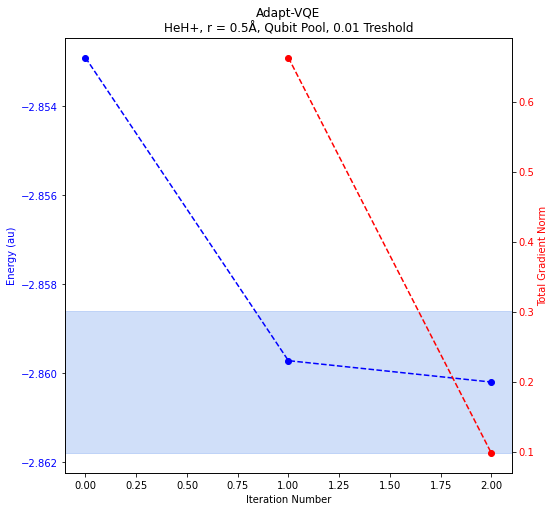

In [ ]:
treshold = 0.01
iterationNumber = len(result["coefficients"])
iterationLabels = [iterationLable for iterationLable in range(0,iterationNumber+1)]

gradientNorms = iterations["norms"]
energies = [molecule.hf_energy] + iterations["energies"]

#errors = list( map(lambda x: np.abs(molecule.fci_energy - x),energies)

fig, ax1 = plt.subplots(figsize=[8,8])
title = "Adapt-VQE\n"
title = title + str(name) + ", " # Molecule name
title = title + "r = " + str(bondLength/2) + "Å, " # Radius in angstrom
title = title + str(poolName) + ", " # Pool name
title = title + str(treshold) + " Treshold" # Convergence treshold
plt.title(title)

color1 = 'b'
ax1.plot(iterationLabels, energies, '--o',color = color1)
ax1.tick_params(axis='y', labelcolor = color1)

# Shade area within chemical accuracy
exactEnergy = molecule.fci_energy
minAccuracy = exactEnergy - chemicalAccuracy
maxAccuracy = exactEnergy + chemicalAccuracy
l = ax1.axhspan(minAccuracy, maxAccuracy, alpha=0.3, color = 'cornflowerblue')

ax1.set_xlabel("Iteration Number")
ax1.set_ylabel("Energy (au)",color = color1)

color2 = 'r'
ax2 = ax1.twinx()
ax2.plot(iterationLabels[1:], gradientNorms, '--o',color = color2)
ax2.tick_params(axis='y', labelcolor = color2)
ax2.set_ylabel("Total Gradient Norm",color = color2)


plt.show()